In [1]:
#!pip install pycaret googletrans nltk spacy sentence_transformers
#python -m spacy download en_core_web_sm

# Problemset 2

<div class="alert alert-block alert-success">
 
You work for a company that provides sentiment analysis services to restaurants. The company has provided you with a dataset of reviews (restaurant-reviews.csv) for different restaurants located in Kiel.

The dataset contains the following columns:

* name: Name of the restaurant
* restaurant_url: URL of the restaurant on the tripadvisor website
* title: Title of the review
* text: Text of the review
* rating: Rating of the review (1-5)
 
Your task is to carry out a machine learning experiment to predict the rating of a review on a scale from 1- 5 based only on textual information of the review. As is typical for real-life data, the dataset is not perfectly clean and may contain certain issues that need to be addressed.

</div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparations
<div class="alert alert-block alert-success">

* Summarize key characteristics of the data (review lengths, missing values, etc. ) and visualize two of them.
</div>

In [3]:
df = pd.read_csv('restaurant-reviews.csv')
df.head()

,name,restaurant_url,title,text,rating
0,Der Bauch von Kiel,https://www.tripadvisor.com/Restaurant_Review-...,Friendly staff - convenient location.,Walking distance from our hotel (Tom Kyle). No...,3.0
1,Cup & Cino Coffeehouse,https://www.tripadvisor.com/Restaurant_Review-...,Nice,Pleasant staff.. nice plate of nacho chips.. g...,5.0
2,Fuego del Sur,https://www.tripadvisor.com/Restaurant_Review-...,the only thing good was the steak,"good thing the steak was good, that's the leas...",2.0
3,Langengrad,https://www.tripadvisor.com/Restaurant_Review-...,"Nice view, nice food, reasonable price",The restaurant is located at the fourth floor ...,5.0
4,Fischers Fritz,https://www.tripadvisor.com/Restaurant_Review-...,A celebration to my mouth....,Excellent restaurant. One of my best in this a...,4.0


<div class="alert alert-info">

The dataset comprises 1,000 reviews covering 129 unique restaurants, with no missing values present.
</div>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   restaurant_url  1000 non-null   object 
 2   title           1000 non-null   object 
 3   text            1000 non-null   object 
 4   rating          1000 non-null   float64
dtypes: float64(1), object(4)
memory usage: 39.2+ KB


In [5]:
df['rating'] = df['rating'].astype('int')

In [6]:
df['name'].nunique()

129

### Viz 1

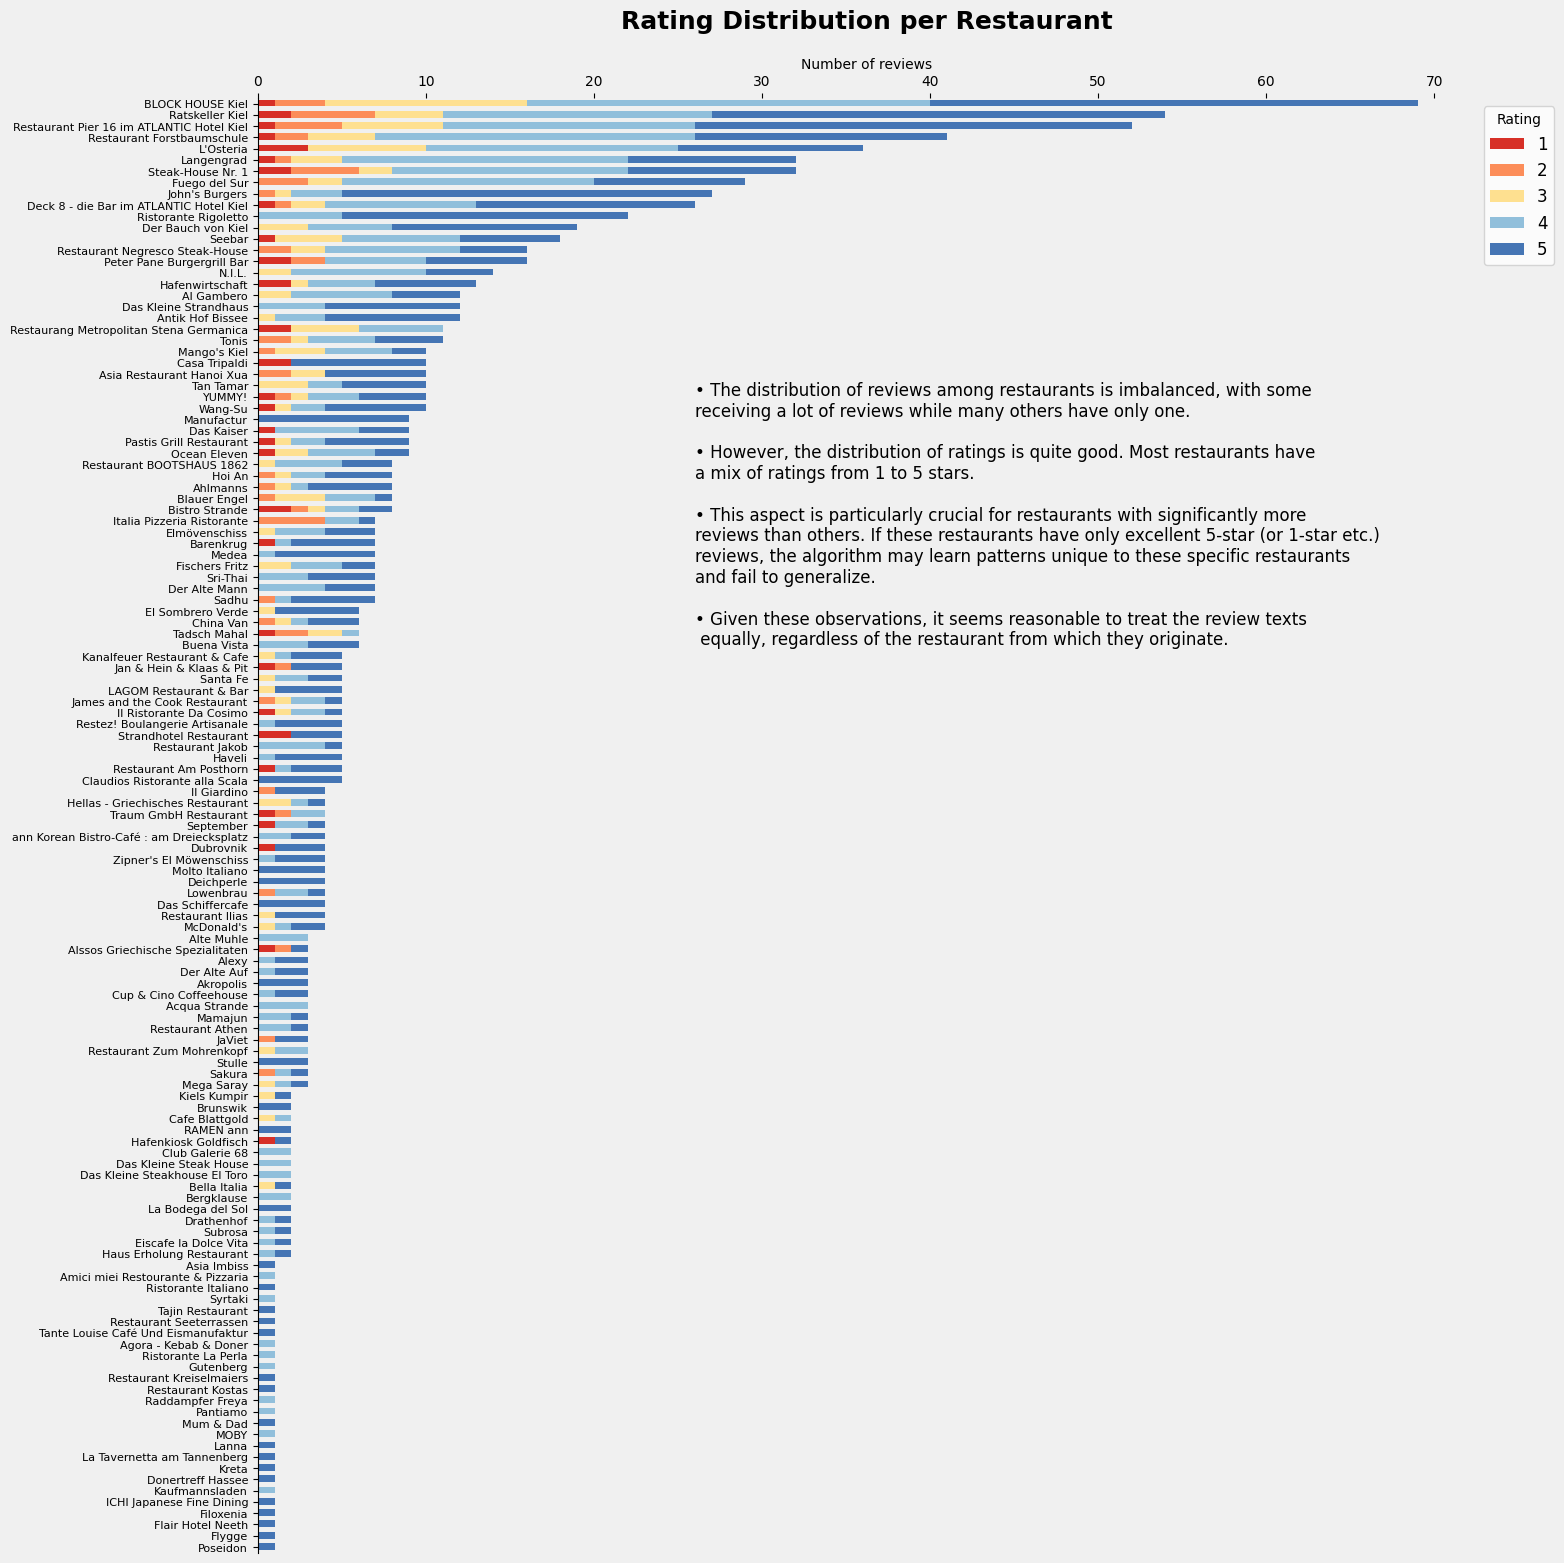

In [7]:
review_counts = df.groupby(['name', 'rating']).size().unstack(fill_value=0)
review_counts['total'] = review_counts.sum(axis=1)
review_counts = review_counts.sort_values('total', ascending=True).drop('total', axis=1)

fig, ax = plt.subplots(figsize=(16, 16))
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

color = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']

review_counts.plot(kind='barh', stacked=True, ax=ax, color=color)

for container in ax.containers:
    plt.setp(container, height=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylabel('')

plt.xlabel('Number of reviews')

plt.title(
    'Rating Distribution per Restaurant',
    fontsize=18, fontweight='bold', pad=50
)

plt.yticks(fontsize=8)
plt.grid(False)

plt.legend(title='Rating', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)

comment = (
    '• The distribution of reviews among restaurants is imbalanced, with some\n'
    'receiving a lot of reviews while many others have only one.\n'
    '\n'
    '• However, the distribution of ratings is quite good. Most restaurants have\n'
    'a mix of ratings from 1 to 5 stars.\n'
    '\n'
    '• This aspect is particularly crucial for restaurants with significantly more\n'
    'reviews than others. If these restaurants have only excellent 5-star (or 1-star etc.)\n'
    'reviews, the algorithm may learn patterns unique to these specific restaurants\n'
    'and fail to generalize.\n'
    '\n'
    '• Given these observations, it seems reasonable to treat the review texts\n'
    ' equally, regardless of the restaurant from which they originate.'
)

ax.text(
    x=26, y=80, 
    s=comment,
    fontsize=12, color='black'
)

plt.tight_layout(pad=2.0)
plt.show()

<div class="alert alert-info">

The data consists of five columns: 'name', 'restaurant_url', 'title', 'text', and 'rating'. For my analysis, I decided to merge the title and text of the review, acknowledging the risk that some duplicates between title and text may influence the results.

</div>


In [8]:
df['text_combined'] = df.apply(
    lambda row: row['title'] + " " + row['text'],
    axis=1
)

In [9]:
df.head()

,name,restaurant_url,title,text,rating,text_combined
0,Der Bauch von Kiel,https://www.tripadvisor.com/Restaurant_Review-...,Friendly staff - convenient location.,Walking distance from our hotel (Tom Kyle). No...,3,Friendly staff - convenient location. Walking ...
1,Cup & Cino Coffeehouse,https://www.tripadvisor.com/Restaurant_Review-...,Nice,Pleasant staff.. nice plate of nacho chips.. g...,5,Nice Pleasant staff.. nice plate of nacho chip...
2,Fuego del Sur,https://www.tripadvisor.com/Restaurant_Review-...,the only thing good was the steak,"good thing the steak was good, that's the leas...",2,the only thing good was the steak good thing t...
3,Langengrad,https://www.tripadvisor.com/Restaurant_Review-...,"Nice view, nice food, reasonable price",The restaurant is located at the fourth floor ...,5,"Nice view, nice food, reasonable price The res..."
4,Fischers Fritz,https://www.tripadvisor.com/Restaurant_Review-...,A celebration to my mouth....,Excellent restaurant. One of my best in this a...,4,A celebration to my mouth.... Excellent restau...


### Viz 2 

In [10]:
df['text_length'] = df['text_combined'].str.len()

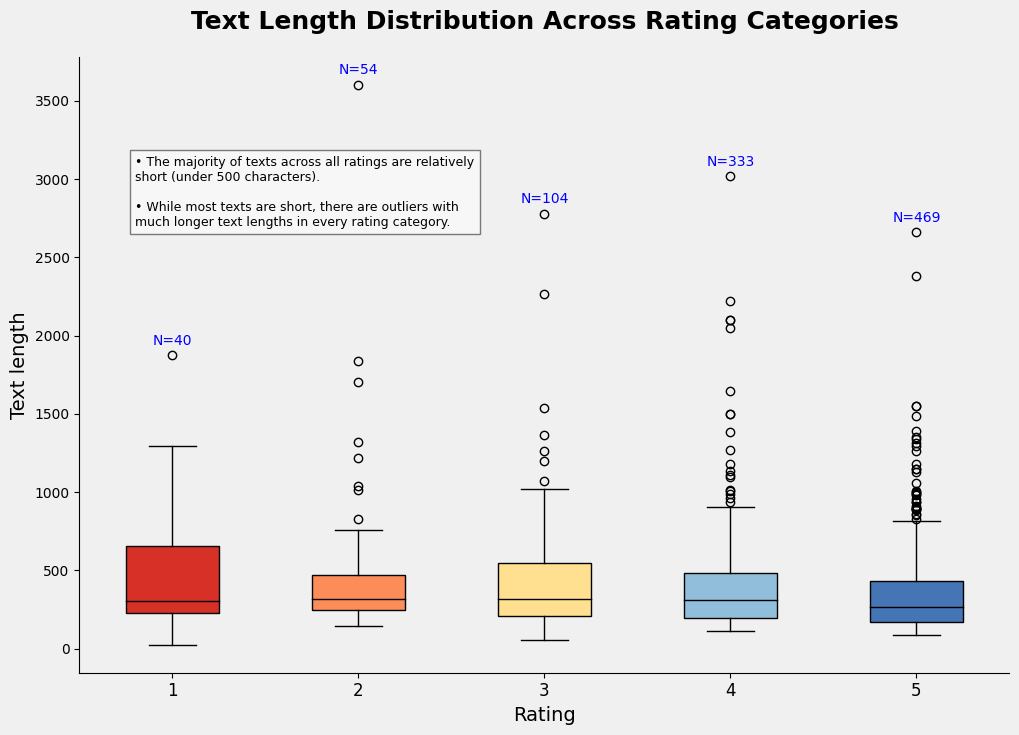

In [11]:
rating_categories = np.unique(df['rating'])
text_lengths = [df[df['rating'] == r]['text_length'] for r in rating_categories]
color_map = dict(zip(rating_categories, color))

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('#f0f0f0')

bp = ax.boxplot(text_lengths, patch_artist=True, showfliers=True)

for box, med, color_key in zip(bp['boxes'], bp['medians'], rating_categories):
    box.set(facecolor=color_map[color_key])
    med.set(color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Rating', fontsize=14)
ax.set_ylabel('Text length', fontsize=14)
ax.set_title(
    'Text Length Distribution Across Rating Categories',
    fontsize=18, fontweight='bold', pad=20
)
ax.set_xticks(range(1, len(rating_categories) + 1))
ax.set_xticklabels(rating_categories, fontsize=12)

comment = (
    '• The majority of texts across all ratings are relatively\n'
    'short (under 500 characters).\n'
    '\n'
    '• While most texts are short, there are outliers with\n'
    'much longer text lengths in every rating category.'
)

ax.text(
    x=0.8, y=max(df['text_length']) - 900,
    s=comment,
    fontsize=9, color='black',
    bbox=dict(facecolor='white', alpha=0.5)
)

for i, length_list in enumerate(text_lengths):
    size = len(length_list)
    ax.text(
        i + 1, max(length_list) + 50,
        f'N={size}',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontsize=10, color='blue'
    )

ax.grid(False)
plt.show()

 <div class="alert alert-block alert-success">


* Describe: What are issues with the data? How will you address these issues?

 </div>

#### Issue 1: German text
<div class="alert alert-info">

The majority of reviews are in English, but during the first examination, I discovered some written in German. There could be reviews in other languages as well, which require further detailed checking. Such review texts are likely to be misclassified when utilizing Vader and machine learning models unless they are preprocessed first.

Since this segment is relatively small, I decided to detect and translate them into English to ensure consistency across the dataset. I initially considered using Huggingface models, but they often truncate texts. Therefore, for simplicity, I opted to use the Python package <b>googletrans</b>.

<b> Firstly, I started with running language detection. </b>

</div>

In [12]:
import nest_asyncio
import asyncio
from googletrans import Translator

In [13]:
nest_asyncio.apply()
translator = Translator()

async def detect_language_async(text):
    detection = await translator.detect(text)
    return detection.lang

df['language'] = df['text_combined'].apply(
    lambda text: asyncio.run(detect_language_async(text))
)

In [14]:
df['language'].value_counts()

language
en    962
de     36
es      1
sw      1
Name: count, dtype: int64

<div class="alert alert-info">

A total of 36 reviews were detected as German. Additionally, one review was detected as Spanish and another as Swedish. Fortunately, both reviews include English translations in the text, so I just need to remove the Spanish and Swedish parts. 

For these two special cases, I manually adjusted them. However, for real-life applications, a proper pipeline should be developed to effectively manage similar cases.

One remark here: if the algorithm can detect texts with a mixture of languages, it gives me confidence that all other reviews are purely in English.
</div>

In [15]:
df.loc[df['language'] == 'es', 'text_combined']

258    Do you want a twist in Kiel? try this one [ENG...
Name: text_combined, dtype: object

In [16]:
df.loc[258, 'text_combined']

'Do you want a twist in Kiel? try this one [ENG] It has a buffet with a mix of Chinesse, Mongolian and Japanese food. Excellent service, great taste and very confortable environment. [ESP] Tiene un muy buen buffet de comida China, Mongolesa y Japonesa. Excelente servicio, gran sabor y un ambiente confortable.'

In [17]:
df.loc[258, 'text_combined'] = df.loc[258, 'text_combined'].split('[ESP]')[0]
df.loc[258, 'text_combined']

'Do you want a twist in Kiel? try this one [ENG] It has a buffet with a mix of Chinesse, Mongolian and Japanese food. Excellent service, great taste and very confortable environment. '

In [18]:
df[df['language'] == 'sw']['text_combined']

680    Safi sana Nimefika hapa mwaka jana na nimepend...
Name: text_combined, dtype: object

In [19]:
df.loc[680, 'text_combined']

"Safi sana Nimefika hapa mwaka jana na nimependa sana. Chakula hapa ni tamu sana. Sija subiri muda mrefu sana na nime wesa ku chagua pasta yangu hapo hapo ambayo wana tengenesa. Kuna watu wengi sana na nisehemu nzuri sana ku kaa na kuongea na marafiki. Asanteni I came here last year and really enjoyed myself. The food is very nice and I didn't have to wait long at all. I was able to pick my own pasta which they all make themselves. This is a very popular place and is great for hanging out and chatting to friends. Thanks"

In [20]:
df.loc[680, 'text_combined'] = df.loc[680, 'text_combined'].split('Asanteni')[1]
df.loc[680, 'text_combined']

" I came here last year and really enjoyed myself. The food is very nice and I didn't have to wait long at all. I was able to pick my own pasta which they all make themselves. This is a very popular place and is great for hanging out and chatting to friends. Thanks"

<div class="alert alert-info">

<b>Next, I translated the 36 German reviews. I updated the text_combined column by overwriting the German texts with their translations. </b>
</div>

In [21]:
reviews_de = df[df['language'] == 'de']['text_combined']
reviews_de

5      Kiels Kumpir- Neues, leckeres Restaurant in Ki...
13     Fein und lecker Jedes Mal ein Überraschung und...
112    Guter Grieche Das Essen (Fleischplatte) hat se...
121    ... wie in einer anderen Welt Dank der übrigen...
185    Einfach gut! Sehr leckeres Essen und netter Se...
201    Sensationelles Silvesteressen!!!! Sensationell...
228    Gehört zu den führenden Restaurants in Kiel! Z...
274    Total Klasse! Wir haben schon zahlreiche griec...
289    Toller Service, incl. Speisen Ein Italiener de...
294    Sehr gutes Essen ... Sehr gutes Restaurant. Di...
306    Fantastische Eissorten am Holstenplatz Sehr gu...
313    Lecker aber... Das Essen ist lecker, daran zwe...
319    Empfehlenswert Superzentral und in der Nähe de...
332    Unterer Durchschnitt Es gibt im Ort keine gute...
343    Sehr zu Empfehlen! Gutes Restaurant mit sehr g...
349    Eine kleine Gourmetperle am Burgerhimmel! Ein ...
359    Besuch am 15.05.2015 In einer eher ärmlich zu ...
384    Abendessen Das Essen war

In [22]:
async def translate_text(text, translator):
    translated_response = await translator.translate(text, target_language='en')
    translated_text = translated_response.text
    return translated_text

async def translate_german_entries_async(df, translator):
    german_reviews_index = df[df['language'] == 'de'].index
    tasks = [
        translate_text(df.loc[idx, 'text_combined'], translator)
        for idx in german_reviews_index
    ]
    translations = await asyncio.gather(*tasks)
    df.loc[german_reviews_index, 'text_combined'] = translations

def main_translate_german_entries(df, translator):
    asyncio.run(translate_german_entries_async(df, translator))

In [23]:
main_translate_german_entries(df, translator)

In [24]:
df[df['language'] == 'de']['text_combined']

5      Kiels Kumpir- New, delicious restaurant in Kie...
13     Fine and delicious every time a surprise and a...
112    Good Greek the food (meat plate) tasted very g...
121    ... As in another world thanks to the other re...
185    Just good! Very tasty food and nice service. A...
201    Sensational New Year's Eve !!!! Sensational Ne...
228    Belongs to the leading restaurants in Kiel! Th...
274    Totally great! We have already "honored" numer...
289    Great service, including dishes an Italian of ...
294    Very good food ... very good restaurant. The s...
306    Fantastic types of ice cream at Holstenplatz V...
313    Delicious but ... the food is delicious, nobod...
319    Recommended super central and near the train s...
332    Lower average There is no good gastronomy in t...
343    Highly recommended! Good restaurant with very ...
349    A little gourmet pearl in the burger sky! A sm...
359    Visit on May 15th, 2015 in a rather poor area ...
384    Dinner The food was very

#### Issue 2: Class imbalance

<div class="alert alert-info">

As highlighted earlier, the dataset contains more 5-star and 4-star ratings than 1-star ratings and others. This imbalance suggests that metrics like accuracy may not sufficiently reflect the model's performance on the less frequent classes.
</div>

In [25]:
df['rating'].value_counts()

rating
5    469
4    333
3    104
2     54
1     40
Name: count, dtype: int64

<div class="alert alert-info">

To tackle this problem, I ensured stratification when splitting the training and test sets and selected additional metrics beyond accuracy (see below).
</div>

 <div class="alert alert-block alert-success">

* Split the dataset into training and test set.
 </div>

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
corpus_train, corpus_test, y_train, y_test = train_test_split(
    df['text_combined'], 
    df['rating'], 
    test_size=0.3, 
    random_state=1,
    stratify=df['rating'], 
    shuffle=True
)

 <div class="alert alert-block alert-success">

* State which metric(s) you will use to evaluate the performance of your classification models, and why you chose it/them.

 </div>

<div class="alert alert-info">

Even though accuracy is not sufficient as the main metric given the class imbalance, I won't overlook it entirely, because in part 3, when comparing Huggingface models, they mainly use accuracy as the metric for their evaluation, so I need to get a sense of how well they would perform.

However, my focus is more on precision, recall, and F1 score for each class. These metrics can be easily extracted using the classification report from scikit-learn. I also use a confusion matrix to visualize where misclassifications occur. This helps in interpreting specific areas where model adjustments may be required.
</div>

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [29]:
def evaluate_model(y_true, y_pred, labels=['1', '2', '3', '4', '5']):
    print("Classification Report:")
    print(
        classification_report(
            y_true, y_pred,
            target_names=labels,
            zero_division=0
        )
    )
    
    conf_mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    disp.plot()
    
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

# 2. Baseline Models

 <div class="alert alert-block alert-success">

* Implement two simple baselines and evaluate their performance on the test set:
    * (a) Naive classifier: e.g. random guessing or majority class
    * (b) Vader. Hint: you need to convert Vader scores to a class via suitable thresholds.
    
 </div>

### 2.1. Naive classifier (Majority class) - worst performance among all solutions

In [30]:
from collections import Counter

In [31]:
majority_class = Counter(y_train).most_common(1)[0][0]

y_pred_naive = [majority_class] * len(corpus_test)

print("Predicted classes:", y_pred_naive)

Predicted classes: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00       100
           5       0.47      1.00      0.64       141

    accuracy                           0.47       300
   macro avg       0.09      0.20      0.13       300
weighted avg       0.22      0.47      0.30       300



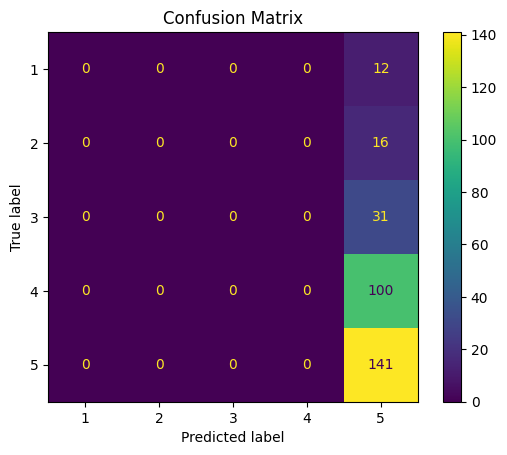

In [32]:
eval_naive = evaluate_model(y_test, y_pred_naive)
eval_naive

### 2.2. Vader - better performance than Naive classifier

In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\NgocM\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [35]:
compound_scores = corpus_test.apply(lambda x: vader.polarity_scores(x)['compound'])

In [36]:
def map_to_stars(score, thresh_5_stars, thresh_4_stars, thresh_3_stars, thresh_2_stars):
    if score >= thresh_5_stars:
        return 5  # 5 stars = very positive
    elif score >= thresh_4_stars:
        return 4  # 4 stars - positive
    elif score > thresh_3_stars:
        return 3  # 3 stars - neutral
    elif score > thresh_2_stars:
        return 2  # 2 stars - negative
    else:
        return 1  # 1 stars - very negative

Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.50      0.43        12
           2       0.22      0.12      0.16        16
           3       0.00      0.00      0.00        31
           4       0.38      0.31      0.34       100
           5       0.58      0.79      0.67       141

    accuracy                           0.50       300
   macro avg       0.31      0.35      0.32       300
weighted avg       0.43      0.50      0.45       300



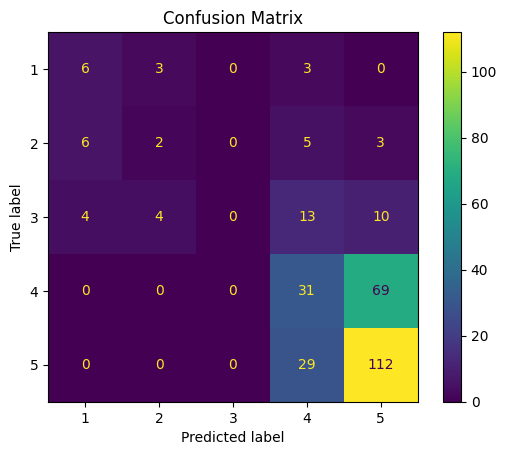

In [37]:
# Orient towards the threshold recommended by the developer
y_pred_vader_1 = compound_scores.apply(
    lambda x: map_to_stars(x, 0.90, 0.05, -0.05, -0.50)
)

eval_vader_1 = evaluate_model(y_test, y_pred_vader_1)
eval_vader_1

 <div class="alert alert-block alert-success">

* Can you improve the performance of the baselines by tuning the thresholds?

</div>

<div class="alert alert-info">

Yes, though not significantly.
</div>

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.42      0.48        12
           2       0.45      0.31      0.37        16
           3       0.38      0.10      0.15        31
           4       0.42      0.13      0.20       100
           5       0.55      0.94      0.69       141

    accuracy                           0.53       300
   macro avg       0.47      0.38      0.38       300
weighted avg       0.48      0.53      0.45       300



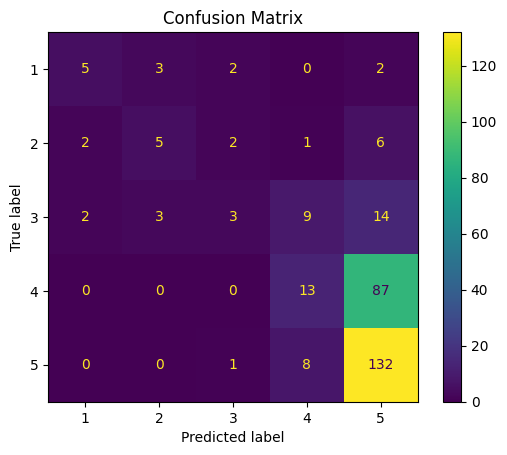

In [38]:
# If the threshold is divided more evenly, the results do improve a bit here.
y_pred_vader_2 = compound_scores.apply(
    lambda x: map_to_stars(x, 0.75, 0.25, -0.25, -0.75)
)

eval_vader_2 = evaluate_model(y_test, y_pred_vader_2)
eval_vader_2

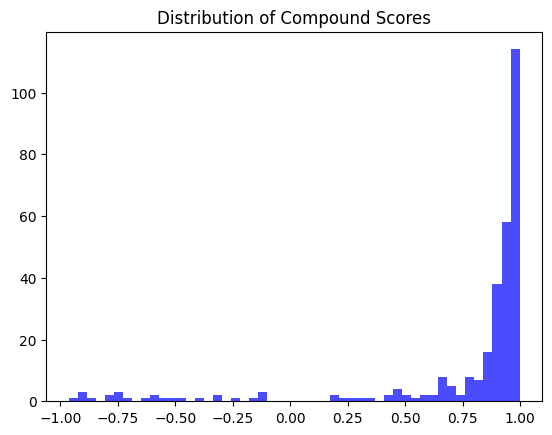

In [39]:
compound_scores.hist(bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Compound Scores') 
plt.gca().grid(False)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.50      0.43        12
           2       0.22      0.12      0.16        16
           3       0.26      0.29      0.28        31
           4       0.35      0.07      0.12       100
           5       0.56      0.87      0.68       141

    accuracy                           0.49       300
   macro avg       0.35      0.37      0.33       300
weighted avg       0.43      0.49      0.41       300



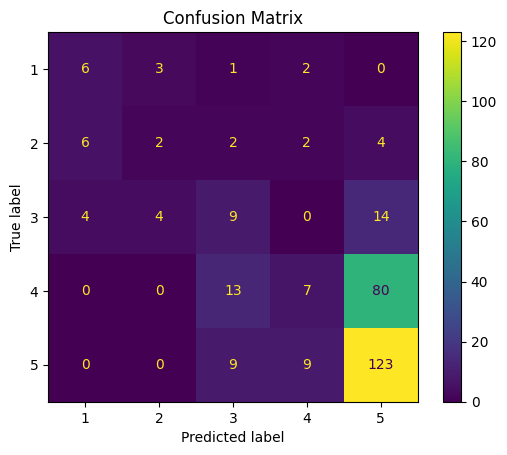

In [40]:
#If I try to fit the thresholds to the distributions above (though generally not recommended), the performance doesn't seem to improve
y_pred_vader_3 = compound_scores.apply(
    lambda x: map_to_stars(x, 0.85, 0.75, 0.0, -0.5)
)

eval_vader_3 = evaluate_model(y_test, y_pred_vader_3)
eval_vader_3

 <div class="alert alert-block alert-success">

* Identify one review that is strongly misclassified by Vader. Which parts of the review and which properties of the Vader algorithm could be responsible for this? 
</div>

In [41]:
strongly_misclassified_review = corpus_test[
    (y_test == 1) & (y_pred_vader_2 == 5)
].iloc[1]

print(strongly_misclassified_review)

Supermarket quality & no good service I ordered my steak rare. I got it medium -well done. I ordered mixed vegetables. I got green beans. Service never asked how it tasted... The taste of everything was really not how it should be. This is NOT good meat. Shame on you! I'll never return here.


In [42]:
polarity_scores = vader.polarity_scores(strongly_misclassified_review)
print(polarity_scores)

{'neg': 0.039, 'neu': 0.773, 'pos': 0.189, 'compound': 0.8199}


<div class="alert alert-info">

This review has a very high compound score but Vader detected primarily neutral words from it. 

A disadvantage of Vader is that it doesn't effectively account for word context. For instance, "well done" in this review refers to the steak, which the reviewer considers negatively, yet Vader detects it as positive due to its rule set.
</div>

# 3. Machine Learning Experiment

<div class="alert alert-block alert-success">

* Train a supervised machine learning model based on Bag-of-Words features and a classification model of your choice. Don’t carry out any text preprocessing and choose default parameters here.
</div>

In [43]:
from sklearn.linear_model import LogisticRegression

def run_logistic_regression(X_train, y_train, X_test, y_test, corpus_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    eval_df = pd.DataFrame({
        'text': corpus_test,
        'prediction': predictions,
        'label': y_test
    })
    print(eval_df.head())
    evaluation_results = evaluate_model(eval_df['label'], eval_df['prediction'])
    
    return evaluation_results

### 3.1. Experiment 1: model performs better than Naive classifier and Vader
* Text preprocessing: None
* Feature engineering: <b>Bag-of-Words</b>
* ML model: Logistic Regression (with default parameters)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
bow = CountVectorizer()
bow.fit(corpus_train)

X_train_1 = bow.transform(corpus_train).toarray()
X_test_1 = bow.transform(corpus_test).toarray()
X_test_1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [46]:
pd.DataFrame(
    X_train_1,
    columns=bow.get_feature_names_out(),
    index=corpus_train
).head(2)

,00,03,10,100,102,10am,10pm,11,11am,12,...,yr,yum,yummmmy,yummy,zackfarsch,zeik,zeus,zitronen,zucchini,zum
text_combined,,,,,,,,,,,,,,,,,,,,,
"The best Lava Steak i Kiel The best Lava Steak in Kiel , food was perfect, staf is friendly and very professional, everything on time, my experience is telling me to visit again Fuego del Sur Kiel",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"just an ""ok"" place, nothing more The atmosphere is typical chinese, and the owner is nice, but sadly I have nothing good to say about the food...It's ok for a cheap big lunch. I will not be returning...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


                                                  text  prediction  label
867  The very best We have travelled 550 miles just...           5      5
370  Nice atmosphere inside, huge biergarten, famil...           5      2
537  Very good steak We were told about the restaur...           5      4
181  If you are into meat. They serve great meat an...           5      4
170  nice and cozy dinner for 2 We had dinner 2 eve...           4      5
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.33      0.42        12
           2       0.60      0.38      0.46        16
           3       0.57      0.26      0.36        31
           4       0.46      0.48      0.47       100
           5       0.63      0.74      0.68       141

    accuracy                           0.57       300
   macro avg       0.57      0.44      0.48       300
weighted avg       0.56      0.57      0.55       300



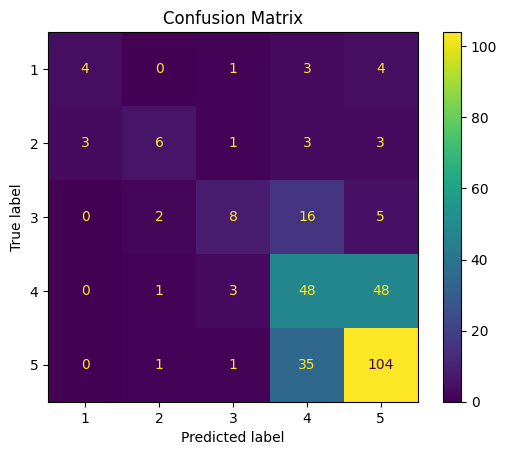

In [47]:
eval_exp_1 = run_logistic_regression(X_train_1, y_train, X_test_1, y_test, corpus_test)
eval_exp_1

 <div class="alert alert-block alert-success">

* Then try to improve the performance by varying some of the following aspects. Do NOT carry out an exhaustive search, but rather explore selected aspects, according to your own interests:
    * Text preprocessing techniques (lemmatization, stopword removal, removing rare words, etc.)
    * Feature Engineering techniques (TF-IDF, n-grams, embeddings)
    * Machine learning models (SVM, Random Forest, etc.) and/or model hyperparameters
 </div>

### 3.2. Experiment 2: model performs slightly better than in experiment 1 (without text preprocessing)
* Text preprocessing: <b> lemmatization, stopword removal </b>
* Feature engineering: Bag-of-Words
* ML model: Logistic Regression (with default parameters)

In [48]:
import nltk
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [49]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english')).union(ENGLISH_STOP_WORDS)

def preprocess_text(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc]

    cleaned_text = " ".join(
        [word for word in lemmatized if word.lower() not in stop_words and word.isalpha()]
    )
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NgocM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
corpus_train_preprocessed = [preprocess_text(text) for text in corpus_train]
corpus_test_preprocessed = [preprocess_text(text) for text in corpus_test]

In [51]:
bow = CountVectorizer()
bow.fit(corpus_train_preprocessed)

X_train_2 = bow.transform(corpus_train_preprocessed).toarray()
X_test_2 = bow.transform(corpus_test_preprocessed).toarray()

In [52]:
pd.DataFrame(
    X_train_2,
    columns=bow.get_feature_names_out(),
    index=corpus_train
).head(2)
# Some German words appeared, but I didn't investigate in detail. My guess is that they are randomly mentioned in the reviews.

,abendessen,aberration,able,absence,absent,absolut,absolute,absolutely,absolutly,accept,...,yr,yum,yummmmy,yummy,zackfarsch,zeik,zeus,zitronen,zucchini,zum
text_combined,,,,,,,,,,,,,,,,,,,,,
"The best Lava Steak i Kiel The best Lava Steak in Kiel , food was perfect, staf is friendly and very professional, everything on time, my experience is telling me to visit again Fuego del Sur Kiel",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"just an ""ok"" place, nothing more The atmosphere is typical chinese, and the owner is nice, but sadly I have nothing good to say about the food...It's ok for a cheap big lunch. I will not be returning...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


                                                  text  prediction  label
867  The very best We have travelled 550 miles just...           5      5
370  Nice atmosphere inside, huge biergarten, famil...           5      2
537  Very good steak We were told about the restaur...           5      4
181  If you are into meat. They serve great meat an...           3      4
170  nice and cozy dinner for 2 We had dinner 2 eve...           5      5
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.42      0.50        12
           2       0.75      0.38      0.50        16
           3       0.57      0.26      0.36        31
           4       0.49      0.56      0.52       100
           5       0.63      0.70      0.67       141

    accuracy                           0.58       300
   macro avg       0.61      0.46      0.51       300
weighted avg       0.59      0.58      0.57       300



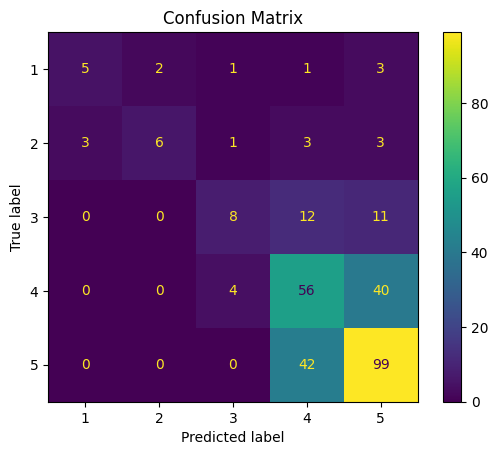

In [53]:
eval_exp_2 = run_logistic_regression(X_train_2, y_train, X_test_2, y_test, corpus_test)
eval_exp_2

### 3.3. Experiment 3: model performs slighty worse than experiment 1 and 2
* Text preprocessing: lemmatization, stopword removal
* Feature engineering: <b> Embeddings </b>
* ML model: Logistic Regression (with default parameters)

In [54]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

In [55]:
X_train_3 = [
    model.encode(text, output_value='sentence_embedding')
    for text in corpus_train_preprocessed
]

X_test_3 = [
    model.encode(text, output_value='sentence_embedding')
    for text in corpus_test_preprocessed
]


                                                  text  prediction  label
867  The very best We have travelled 550 miles just...           5      5
370  Nice atmosphere inside, huge biergarten, famil...           5      2
537  Very good steak We were told about the restaur...           4      4
181  If you are into meat. They serve great meat an...           5      4
170  nice and cozy dinner for 2 We had dinner 2 eve...           4      5
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.42      0.50        12
           2       1.00      0.06      0.12        16
           3       0.20      0.06      0.10        31
           4       0.52      0.51      0.52       100
           5       0.60      0.78      0.68       141

    accuracy                           0.56       300
   macro avg       0.59      0.37      0.38       300
weighted avg       0.55      0.56      0.53       300



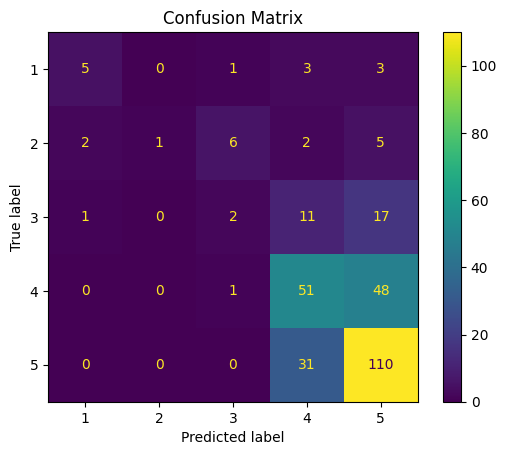

In [56]:
eval_exp_3 = run_logistic_regression(X_train_3, y_train, X_test_3, y_test, corpus_test)
eval_exp_3

### 3.4. Experiment 4: model performs slightly worse than experiment 1 and 2
* Text preprocessing: lemmatization, stopword removal
* Feature engineering: <b> TF-IDF </b>
* ML model: Logistic Regression (with default parameters)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
tfidf = TfidfVectorizer()

tfidf.fit(corpus_train_preprocessed)

X_train_4 = tfidf.transform(corpus_train_preprocessed).toarray()
X_test_4 = tfidf.transform(corpus_test_preprocessed).toarray()

In [59]:
pd.DataFrame(
    X_train_4,
    columns=tfidf.get_feature_names_out(),
    index=corpus_train
).head(2)
# Some German words appeared, but I didn't investigate in detail. My guess is that they are randomly mentioned in the reviews.

,abendessen,aberration,able,absence,absent,absolut,absolute,absolutely,absolutly,accept,...,yr,yum,yummmmy,yummy,zackfarsch,zeik,zeus,zitronen,zucchini,zum
text_combined,,,,,,,,,,,,,,,,,,,,,
"The best Lava Steak i Kiel The best Lava Steak in Kiel , food was perfect, staf is friendly and very professional, everything on time, my experience is telling me to visit again Fuego del Sur Kiel",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"just an ""ok"" place, nothing more The atmosphere is typical chinese, and the owner is nice, but sadly I have nothing good to say about the food...It's ok for a cheap big lunch. I will not be returning...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                                                  text  prediction  label
867  The very best We have travelled 550 miles just...           5      5
370  Nice atmosphere inside, huge biergarten, famil...           5      2
537  Very good steak We were told about the restaur...           5      4
181  If you are into meat. They serve great meat an...           5      4
170  nice and cozy dinner for 2 We had dinner 2 eve...           5      5
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.08      0.15        12
           2       1.00      0.06      0.12        16
           3       1.00      0.06      0.12        31
           4       0.52      0.48      0.50       100
           5       0.58      0.84      0.68       141

    accuracy                           0.57       300
   macro avg       0.82      0.31      0.32       300
weighted avg       0.64      0.57      0.51       300



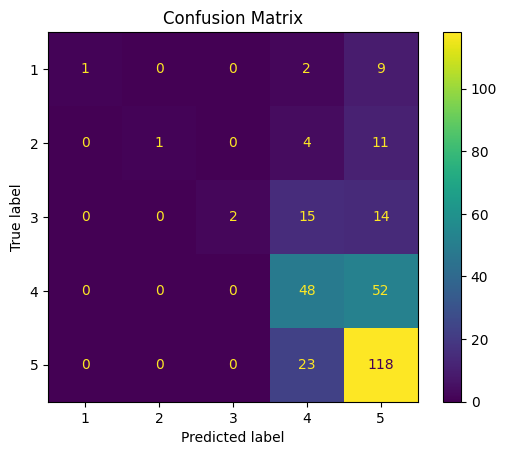

In [60]:
eval_exp_4 = run_logistic_regression(X_train_4, y_train, X_test_4, y_test, corpus_test)
eval_exp_4

### 3.5. Experiment 5: performance quite similar to experiment 3, still slightly worse than experiment 2
* Text preprocessing: lemmatization, stopword removal
* Feature engineering: Bag-of-Words
* ML model: <b>using pycaret to find the best model (using only train data)</b>

In [61]:
from pycaret.classification import setup, compare_models

In [62]:
y_train_np = y_train.to_numpy().reshape(-1, 1) 

In [63]:
combined_array = np.concatenate((X_train_2, y_train_np), axis=1)
combined_array

array([[0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 4]], dtype=int64)

In [64]:
feature_names = bow.get_feature_names_out()
column_names = np.append(feature_names, 'target')

In [65]:
train_df = pd.DataFrame(
    combined_array,
    columns=column_names,
    index=corpus_train
)

In [66]:
exp_clf = setup(
    data=train_df,
    target='target',
    preprocess=False,
    index=False,
    fix_imbalance=True
)


,Description,Value
0,Session id,2216
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(754, 3566)"
4,Transformed data shape,"(754, 3566)"
5,Transformed train set shape,"(527, 3566)"
6,Transformed test set shape,"(227, 3566)"
7,Numeric features,3565


In [67]:
best_models = compare_models(
    include=['lr', 'ridge', 'dt', 'svm', 'nb', 'knn', 'ada', 'lightgbm', 'rf', 'gbc']
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6106,0.0000,0.6106,0.6031,0.5815,0.3632,0.3785,3.8430
rf,Random Forest Classifier,0.5729,0.7821,0.5729,0.5568,0.5148,0.2616,0.3022,0.2750
lightgbm,Light Gradient Boosting Machine,0.5708,0.7394,0.5708,0.5471,0.5477,0.3097,0.3149,0.6150
lr,Logistic Regression,0.5673,0.0000,0.5673,0.5432,0.5401,0.3000,0.3104,0.6670
svm,SVM - Linear Kernel,0.5656,0.0000,0.5656,0.5484,0.5446,0.3046,0.3108,0.0740
dt,Decision Tree Classifier,0.5517,0.6427,0.5517,0.5401,0.5331,0.2908,0.2983,0.0840
ridge,Ridge Classifier,0.5332,0.0000,0.5332,0.5222,0.5167,0.2601,0.2648,0.0630
nb,Naive Bayes,0.4629,0.5670,0.4629,0.4602,0.4485,0.1458,0.1491,0.0640
knn,K Neighbors Classifier,0.4556,0.5840,0.4556,0.4100,0.4184,0.0993,0.1025,0.0700
ada,Ada Boost Classifier,0.4517,0.0000,0.4517,0.4057,0.3843,0.0950,0.1045,0.3060


In [68]:
print(best_models)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=2216, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


<div class="alert alert-info">

Gradient Boosting Classifier seems to be the best model here. This is no wonder, as it generally handles imbalanced datasets well.

Now, I run it on my test data, using the hyperparameters specified above and the data input approach from experiment 2.
</div>

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

In [70]:
model = GradientBoostingClassifier(
    ccp_alpha=0.0,
    criterion='friedman_mse',
    init=None,
    learning_rate=0.1,
    loss='log_loss',
    max_depth=3,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_iter_no_change=None,
    random_state=6964,
    subsample=1.0,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False
)


In [71]:
model.fit(X_train_2, y_train)
y_pred_gbc = model.predict(X_test_2)

In [72]:
eval = pd.DataFrame({
    'text': corpus_test,
    'predictions': y_pred_gbc,
    'label': y_test
})

eval.head(5)


,text,predictions,label
867,The very best We have travelled 550 miles just...,5,5
370,"Nice atmosphere inside, huge biergarten, famil...",5,2
537,Very good steak We were told about the restaur...,5,4
181,If you are into meat. They serve great meat an...,5,4
170,nice and cozy dinner for 2 We had dinner 2 eve...,4,5


Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.25      0.35        12
           2       0.50      0.12      0.20        16
           3       0.50      0.23      0.31        31
           4       0.44      0.39      0.41       100
           5       0.59      0.79      0.68       141

    accuracy                           0.54       300
   macro avg       0.53      0.36      0.39       300
weighted avg       0.53      0.54      0.51       300



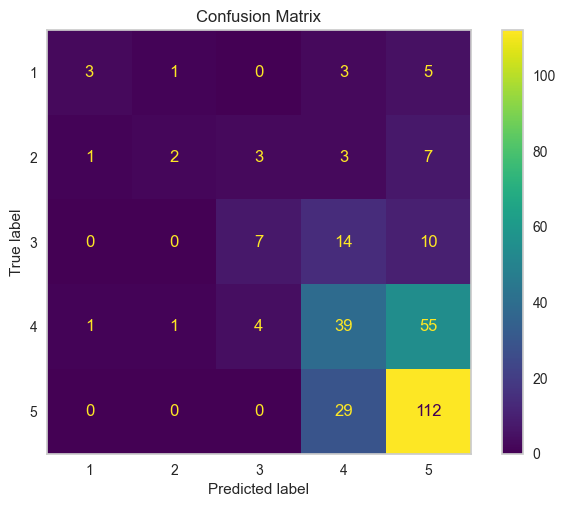

In [73]:
evaluate_model(eval.label, eval.predictions)

 <div class="alert alert-block alert-success">

* Compare the performance of the models you trained in this exercise with the baseline predictions, and describe your learnings: which aspects have a positive impact on the performance?
 </div>

<div class="alert alert-info">

My learning through this exercise is that text processing with lemmatization and stopword removal did have a positive impact. Bag-of-Words seems to work better than embeddings and TF-IDF in this case. It's also confirmed that ensemble models like Gradient Boosting and Random Forest perform better on imbalanced datasets. But the model from experiment 2 still has the best performance sofar on the test dataset (best scores for most of the metrics in all classes).
</div>

<div class="alert alert-block alert-warning">

We can also see through all the experiments so far that the performance won't improve beyond this if we use exact matching. This will be confirmed in the following chapter with the Huggingface models.

I think this quote perfectly encapsulates the entire scenario: ([source](https://huggingface.co/mekes/Bert-User-Review-Rating))

***"The subjective performance of the model is better than the metrices, because it was evaluated regarding meeting the exact correct prediction, so if it reflects 4 instead of 5 it was counted as wrong prediciton. Even though the prediction was way better than predicting 1 for a 5 review."*** 

Perhaps it is worth experimenting by approaching this as a regression task instead of a classification task.
</div>


# 4. Extensions
For this part, I chose extension 2.

 <div class="alert alert-block alert-success">

 <b> Extension 2: Finetuned Transformers </b> 

* Investigate three transformer models on Huggingface that are possibly suitable for this task. Summarize their key characteristics (as shown in their documentation) in a table. Choose the most promising model and justify your choice.
 </div>

<div class="alert alert-info">

Ideally, the best scenario would be to find a model extensively fine-tuned on restaurant reviews with ratings. However, I couldn't locate any such models with proper documentation. Therefore, I selected three sentiment models fine-tuned on general reviews. These models accept text as input and output ratings on a scale from 1 to 5 stars.
</div>

| Model name                                       | Base model                     | Language support       | Dataset used for finetuning | Performance                                |
|--------------------------------------------------|--------------------------------|------------------------|-----------------------------| -------------------------------------------|
| [nlptown/bert-base-multilingual-uncased-sentiment](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment) | bert-base-multilingual-uncased | Multilingual (uncased) | Product reviews (not accessible) <br>en - 150k <br>nl - 80k <br>de - 137k <br>fr - 140k <br>it - 72k <br>es - 50k  | Accuracy (exact)* - Accuracy (off-by-1)** <br>en - 67% - 95% <br>nl - 57% - 93% <br>de - 61% - 94% <br>fr - 59% - 94% <br>it - 59% - 95% <br>es - 58% - 95%  |
| [kmack/YELP-Review_Classifier](https://huggingface.co/kmack/YELP-Review_Classifier)                     | distilbert-base-uncased        | English                | curated YELP reviews (700k of rows - accessible)  <br> preprocessed by cleaning the reviews to remove unwanted characters and URLs | Performance not specified  |
| [mekes/Bert-User-Review-Rating](https://huggingface.co/mekes/Bert-User-Review-Rating)                    | BERT (exact version unknown)   | English                | Review rating (1300k reviews, not accessible)   | Test metrics: <br>Accuracy: 0.714 <br> F1 Score: 0.695 <br>Loss: 0.698 <br>Recall: 0.714 |


*exact match for the number of stars.

**the percentage of reviews where the number of stars the model predicts differs by a maximum of 1 from the number given by the human reviewer.

<div class="alert alert-info">

Although the documentation for these models all showcasing their potential and suitability for the task, I chose nlptown/bert-base-multilingual-uncased-sentiment due to its popularity, with approximately 1.9 million downloads last month, compared to kmack/YELP-Review_Classifier, which had about 300 downloads, and mekes/Bert-User-Review-Rating, which had only 20 downloads.

The chosen model can handle multiple languages, but I opted to use the English-only version that I have been using so far.
</div>

 <div class="alert alert-block alert-success">
 
* Predict the ratings of the review using the preferred transformer model and compare the performance with your best classification model.
 </div>

In [74]:
from transformers import pipeline, AutoTokenizer

In [75]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
sentiment = pipeline("text-classification", model=model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

Device set to use cpu


In [76]:
def preprocess_and_predict(text):
    tokens = tokenizer(
        text,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    
    result = sentiment(text, truncation=True)[0]
    star_rating = int(result['label'].split()[0])
    
    return star_rating


In [77]:
y_pred_hf_model = corpus_test.apply(preprocess_and_predict) 
# corpus_test has texts without preprocessing (lemmatization and stop-word-removal)

Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.83      0.69        12
           2       0.40      0.38      0.39        16
           3       0.46      0.39      0.42        31
           4       0.63      0.66      0.64       100
           5       0.80      0.78      0.79       141

    accuracy                           0.68       300
   macro avg       0.58      0.61      0.59       300
weighted avg       0.68      0.68      0.68       300



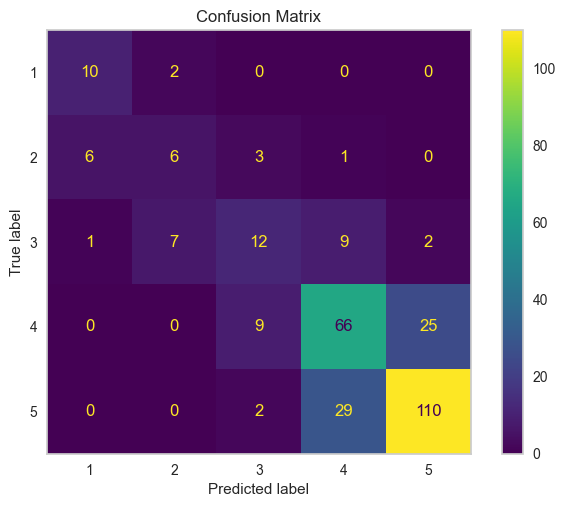

In [78]:
eval_hf_model = evaluate_model(y_test, y_pred_hf_model)

<div class="alert alert-info">

The results are slightly better than those from experiment 2 and, in my opinion, represent the best performance so far.
</div>

 <div class="alert alert-block alert-success">
 
* Reconsider the review that was misclassified by Vader. Is the transformer model able to predict the rating better? Explain why you think this is (or is not) the case.
 </div>

<div class="alert alert-info">

I believe it would predict ratings better because BERT, the base model, uses a transformer architecture that considers textual context. Indeed, the review that was strongly misclassified by Vader is accurately predicted with 1-star, the true rating.
</div>

In [79]:
strongly_misclassified_review

"Supermarket quality & no good service I ordered my steak rare. I got it medium -well done. I ordered mixed vegetables. I got green beans. Service never asked how it tasted... The taste of everything was really not how it should be. This is NOT good meat. Shame on you! I'll never return here."

In [80]:
sentiment(strongly_misclassified_review)

[{'label': '1 star', 'score': 0.812207818031311}]

### Extra: I discovered a series of models fine-tuned on restaurant reviews, but their output is sentiment (positive, negative, neutral, conflict) related to certain detected aspects, rather than ratings from 1 to 5 stars (see example below).

In [81]:
#!pip install setfit
from setfit import AbsaModel

Huggingface links:
* [tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect](https://huggingface.co/tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect)
* [tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity](https://huggingface.co/tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity)

In [82]:
model = AbsaModel.from_pretrained(
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect",
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity",
)

or this version:
* [tomaarsen/setfit-absa-paraphrase-mpnet-base-v2-restaurants-aspect](https://huggingface.co/tomaarsen/setfit-absa-paraphrase-mpnet-base-v2-restaurants-aspect)
* [tomaarsen/setfit-absa-paraphrase-mpnet-base-v2-restaurants-polarity](https://huggingface.co/tomaarsen/setfit-absa-paraphrase-mpnet-base-v2-restaurants-polarity)

In [83]:
#model = AbsaModel.from_pretrained(
#    "tomaarsen/setfit-absa-paraphrase-mpnet-base-v2-restaurants-aspect",
#    "tomaarsen/setfit-absa-paraphrase-mpnet-base-v2-restaurants-polarity",
#)

In [84]:
example = corpus_test[412]
example

'Its a 3 out of 5 Not bad, but didn\'t "wow" me..... Pumpkin soup did not stand out, caesar salad was different and almost very good but it just did not get there, nice bread and free appetizer.... Service was still learning but at least you could tell they were trying to be good.'

In [85]:
model(example)

[{'span': 'Pumpkin soup', 'polarity': 'negative'},
 {'span': 'caesar salad', 'polarity': 'negative'},
 {'span': 'bread', 'polarity': 'positive'},
 {'span': 'appetizer', 'polarity': 'positive'},
 {'span': 'Service', 'polarity': 'positive'}]

<div class="alert alert-info">

I believe this is quite a useful application for restaurant reviews if we don't strictly aim to predict ratings from 1 to 5 stars. Mapping the results to a 1 to 5 rating in this case can be complex and will require additional rules.

One idea is to run the model on the training data first, deriving insights into how the results correspond to ratings from 1 to 5 stars by obtaining the average distribution of each sentiment for each rating. From there, we establish rules to apply to the test data. Additionally, we can use domain knowledge to define the mappings.
</div>

In [86]:
def predict_sentiments(data, model):
    sentiment_results = []
    
    for text in data:
        predictions = model(text)
        
        if not predictions or not isinstance(predictions, list) or not predictions[0]:
            print(f"Unexpected predictions structure: {predictions} for '{text}'")
            sentiment_results.append([])
            continue

        sentiment_results.append(predictions)
    
    return sentiment_results


In [87]:
# Example: Run the model on the first 10 reviews
sentiment_results = predict_sentiments(corpus_test[0:10], model)
sentiment_results

[[{'span': 'Steak', 'polarity': 'positive'}],
 [{'span': 'atmosphere', 'polarity': 'positive'},
  {'span': 'biergarten', 'polarity': 'positive'},
  {'span': 'family', 'polarity': 'positive'},
  {'span': 'summer', 'polarity': 'positive'},
  {'span': 'food', 'polarity': 'positive'},
  {'span': 'service', 'polarity': 'positive'},
  {'span': 'atmosphere', 'polarity': 'positive'},
  {'span': 'biergarten', 'polarity': 'positive'},
  {'span': 'family', 'polarity': 'positive'},
  {'span': 'summer', 'polarity': 'positive'},
  {'span': 'food', 'polarity': 'positive'},
  {'span': 'service', 'polarity': 'positive'},
  {'span': 'guest masses', 'polarity': 'positive'}],
 [{'span': 'steak', 'polarity': 'positive'},
  {'span': 'restaurant', 'polarity': 'positive'},
  {'span': 'reception', 'polarity': 'positive'},
  {'span': 'hotel', 'polarity': 'positive'},
  {'span': 'steak', 'polarity': 'positive'}],
 [{'span': 'meat', 'polarity': 'positive'},
  {'span': 'meat', 'polarity': 'positive'},
  {'span': '